In [1]:
from imaging_functions import *
from aicsimageio import AICSImage
import os
import numpy as np
import matplotlib.pyplot as plt
from cellpose import models
from skimage.io import imread
from skimage.measure import regionprops
from skimage.color import label2rgb
os.environ["CUDA_VISIBLE_DEVICES"] = "2"
import torch
from skimage import exposure
from skimage.transform import rescale
from cellpose import plot
from skimage.measure import regionprops
from skimage.exposure import equalize_adapthist
from skimage import img_as_ubyte
device = torch.device("cuda:0")


03-Jul-25 10:40:48 - bfio.backends - WARNING  - Java backend is not available. This could be due to a missing dependency (jpype).




Welcome to CellposeSAM, cellpose v
cellpose version: 	4.0.5 
platform:       	linux 
python version: 	3.10.13 
torch version:  	2.5.1! The neural network component of
CPSAM is much larger than in previous versions and CPU excution is slow. 
We encourage users to use GPU/MPS if available. 




In [2]:
#czi_filename = '/home/mars/Data/snyder_colab/mix_dilution_FibronectinPDK_24hr_5x_1x_JDF_9may2025-Scene-28-E2-E02.czi'

current_directory = '/home/mars/Data/snyder_colab/'
data_subdirectory = 'data_062725/8may/'
filename = 'mix_dilution_FibronectinPDK_24hr_5x_1x_JDF_9may2025-Scene-54-G10-G10.czi'
czi_filename = current_directory+data_subdirectory+ filename
output_subdirectory = 'mix_dilution_FibronectinPDK_24hr_5x_1x_JDF_9may2025-Scene-54-G10-G10'
output_dir = '/home/mars/Projects/mel_summer/experimental_data/outputs_rgb/' + output_subdirectory +'/enhanced_rgb_frames/'

# Create output directory
os.makedirs(output_dir, exist_ok=True)

img = AICSImage(czi_filename)
num_timepoints = img.dims.T #change to the number "1" for visualizing the first frame in the cells below

for t in tqdm(range(num_timepoints), desc="Saving enhanced RGB frames"):
    blue_raw  = img.get_image_data("YX", T=t, C=0, Z=0)
    green_raw = img.get_image_data("YX", T=t, C=1, Z=0)
    red_raw   = img.get_image_data("YX", T=t, C=2, Z=0)

    blue  = normalize_to_8bit(blue_raw, gamma=1.2, boost=1.5)
    green = normalize_to_8bit(green_raw, gamma=1.0, boost=1.0)
    red   = normalize_to_8bit(red_raw, gamma=0.8, boost=2.5)

    # Suppress green where red is strong
    overlap_mask = red > 50  # adjust threshold if needed
    green[overlap_mask] = green[overlap_mask] * 0.4  # suppress green in overlap

    # Optionally darken background
    composite_intensity = (red.astype(float) + green.astype(float) + blue.astype(float)) / 3
    background_mask = composite_intensity < 15  # adjust threshold
    red[background_mask] = green[background_mask] = blue[background_mask] = 0

    rgb = np.stack([red, green, blue], axis=-1)
    Image.fromarray(rgb).save(f"{output_dir}/frame_{t:03d}.png")
    
#Note about timing - this step takes ~8 minutes for 289 frames

Saving enhanced RGB frames: 100%|███████████| 289/289 [06:53<00:00,  1.43s/it]


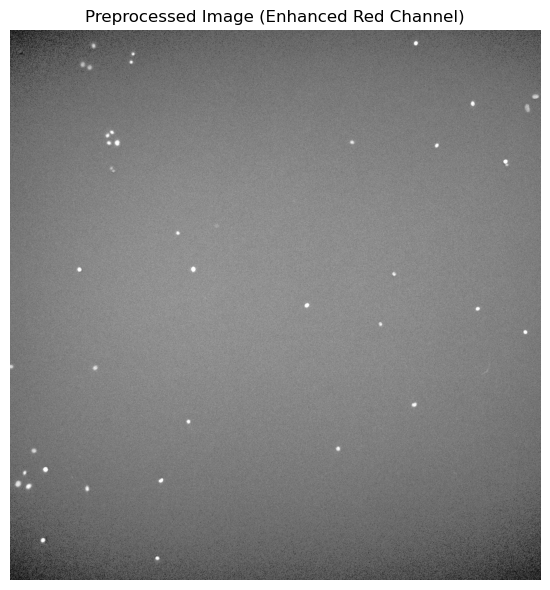

In [3]:
# === Parameters ===
scale_factor = 1.0  # Adjust if nuclei are not ~30 px in output
image_path = output_dir+'frame_010.png'

# === Load RGB image ===
img_rgb = imread(image_path).astype(np.float32) / 255.0  # Normalize to [0, 1]

# === Extract red channel ===
red_channel = img_rgb[..., 0]

# === Apply adaptive histogram equalization to enhance faint red signal ===
red_eq = equalize_adapthist(red_channel, clip_limit=0.01)

# === Optional: Blend with other channels if needed ===
blended = 0.8 * red_eq + 4.0 * img_rgb.mean(axis=-1)
channel_img = np.clip(blended, 0, 1)
#channel_img = red_eq  # use red-enhanced only

# === Rescale image to match expected object size (~30 px nuclei) ===
scaled_img = rescale(
    channel_img,
    scale=scale_factor,
    preserve_range=True,
    anti_aliasing=True
)

# === Convert to uint8 if needed ===
scaled_img = img_as_ubyte(scaled_img)

# === Plot final image used for Cellpose ===
plt.figure(figsize=(6, 6))
plt.imshow(scaled_img, cmap='gray')
plt.title("Preprocessed Image (Enhanced Red Channel)")
plt.axis('off')
plt.tight_layout()
plt.show()


In [4]:
# === Initialize Cellpose model ===
model = models.CellposeModel(device=device)

# === Run Cellpose ===
masks_list, flows_list, styles_list = model.eval(
    [scaled_img],
    diameter=None,     # use default trained scale (≈30 px nuclei)
    augment=True,
    tile_overlap=0.5,
    progress=True,
    cellprob_threshold = -4.0,  # more permissive
    flow_threshold = 0.0  # or even 0.1

)

masks = masks_list[0]


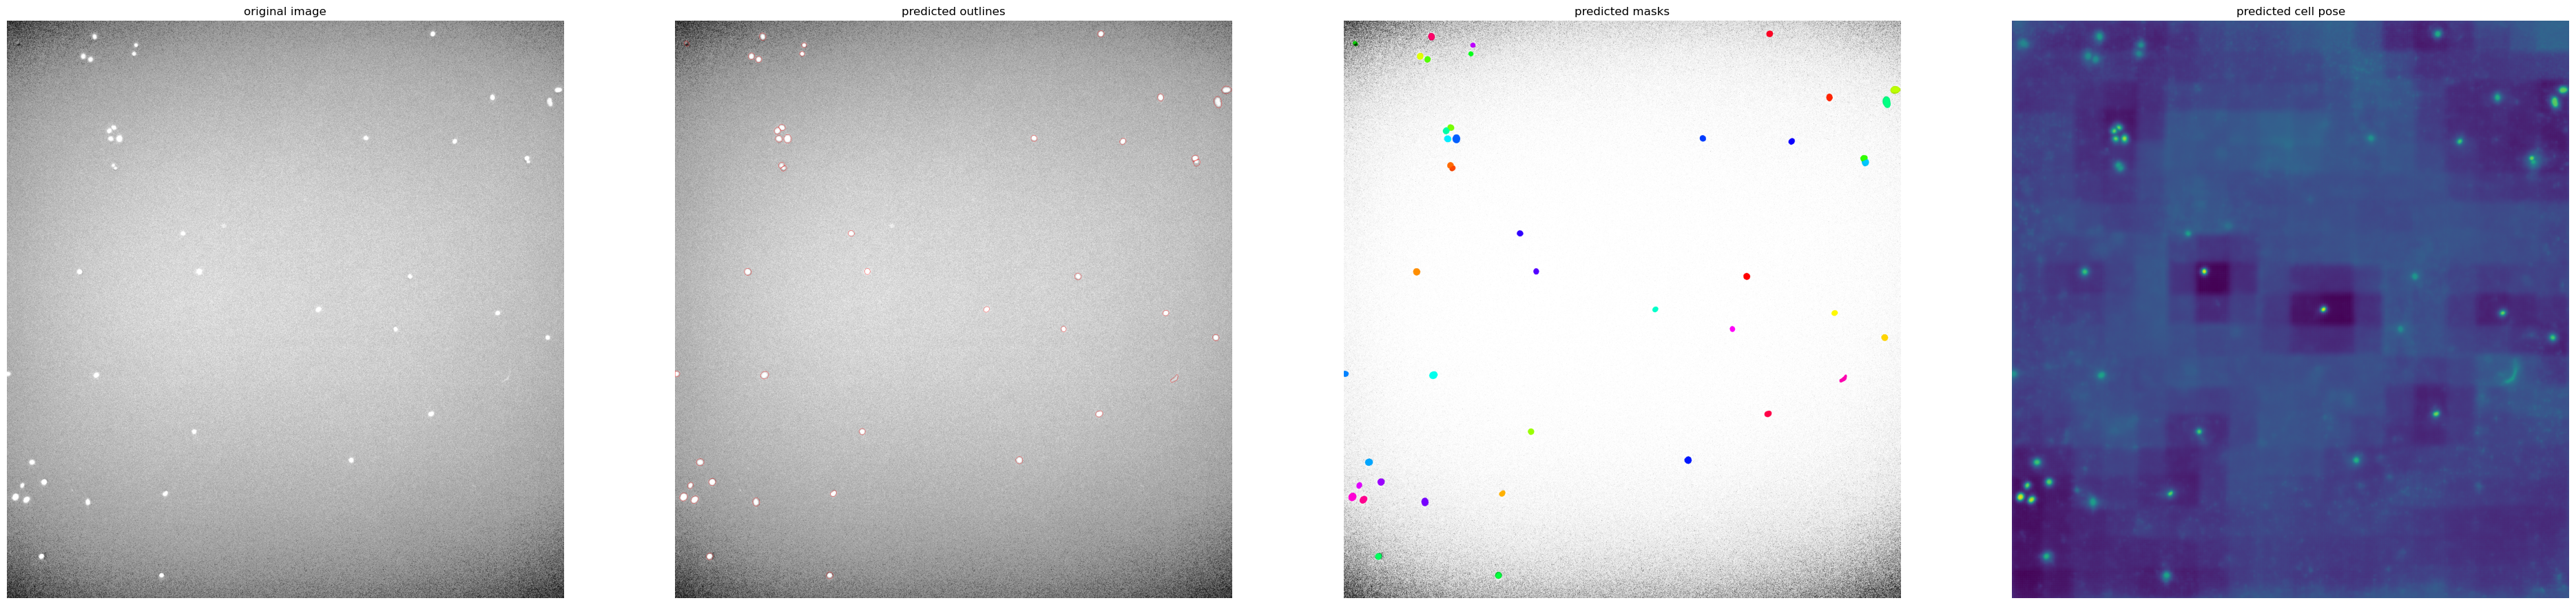

In [5]:
# === Visualize Cellpose Segmentation ===

fig = plt.figure(figsize=(48, 16))  # large figure

plot.show_segmentation(
    fig,
    scaled_img,             # ✅ must match the image Cellpose was run on
    masks_list[0],          # mask output
    flows_list[0][2],       # flow_rgb (used in subplot 4)
    [0, 0]                  # grayscale channel setting
)


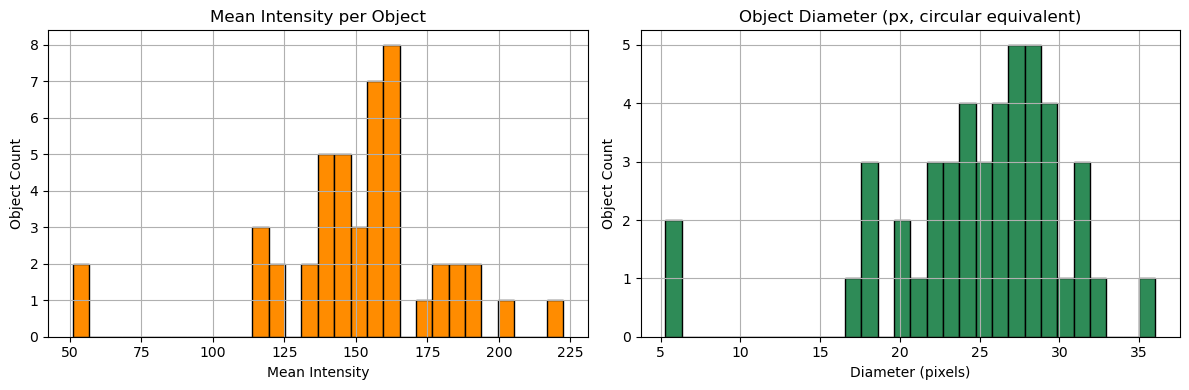

Total objects: 46
Mean intensity range: 50.974 – 222.378
Diameter range: 5.29 – 36.02 px


In [7]:

# Compute region properties
props = regionprops(masks, intensity_image=scaled_img)

mean_intensities = np.array([p.mean_intensity for p in props])
areas = np.array([p.area for p in props])

# Convert area to equivalent circular diameter
diameters = 2.0 * np.sqrt(areas / np.pi)

# Plot histograms
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# === Subplot 1: Mean Intensity ===
axes[0].hist(mean_intensities, bins=30, color='darkorange', edgecolor='black')
axes[0].set_title('Mean Intensity per Object')
axes[0].set_xlabel('Mean Intensity')
axes[0].set_ylabel('Object Count')
axes[0].grid(True)

# === Subplot 2: Equivalent Diameter ===
axes[1].hist(diameters, bins=30, color='seagreen', edgecolor='black')
axes[1].set_title('Object Diameter (px, circular equivalent)')
axes[1].set_xlabel('Diameter (pixels)')
axes[1].set_ylabel('Object Count')
axes[1].grid(True)

plt.tight_layout()
plt.show()

# Print stats
print(f"Total objects: {len(props)}")
print(f"Mean intensity range: {mean_intensities.min():.3f} – {mean_intensities.max():.3f}")
print(f"Diameter range: {diameters.min():.2f} – {diameters.max():.2f} px")


Original objects: 46
Kept after filtering: 44
Intensity ≥ 0.0, Diameter ∈ [13.0, 70.0] px


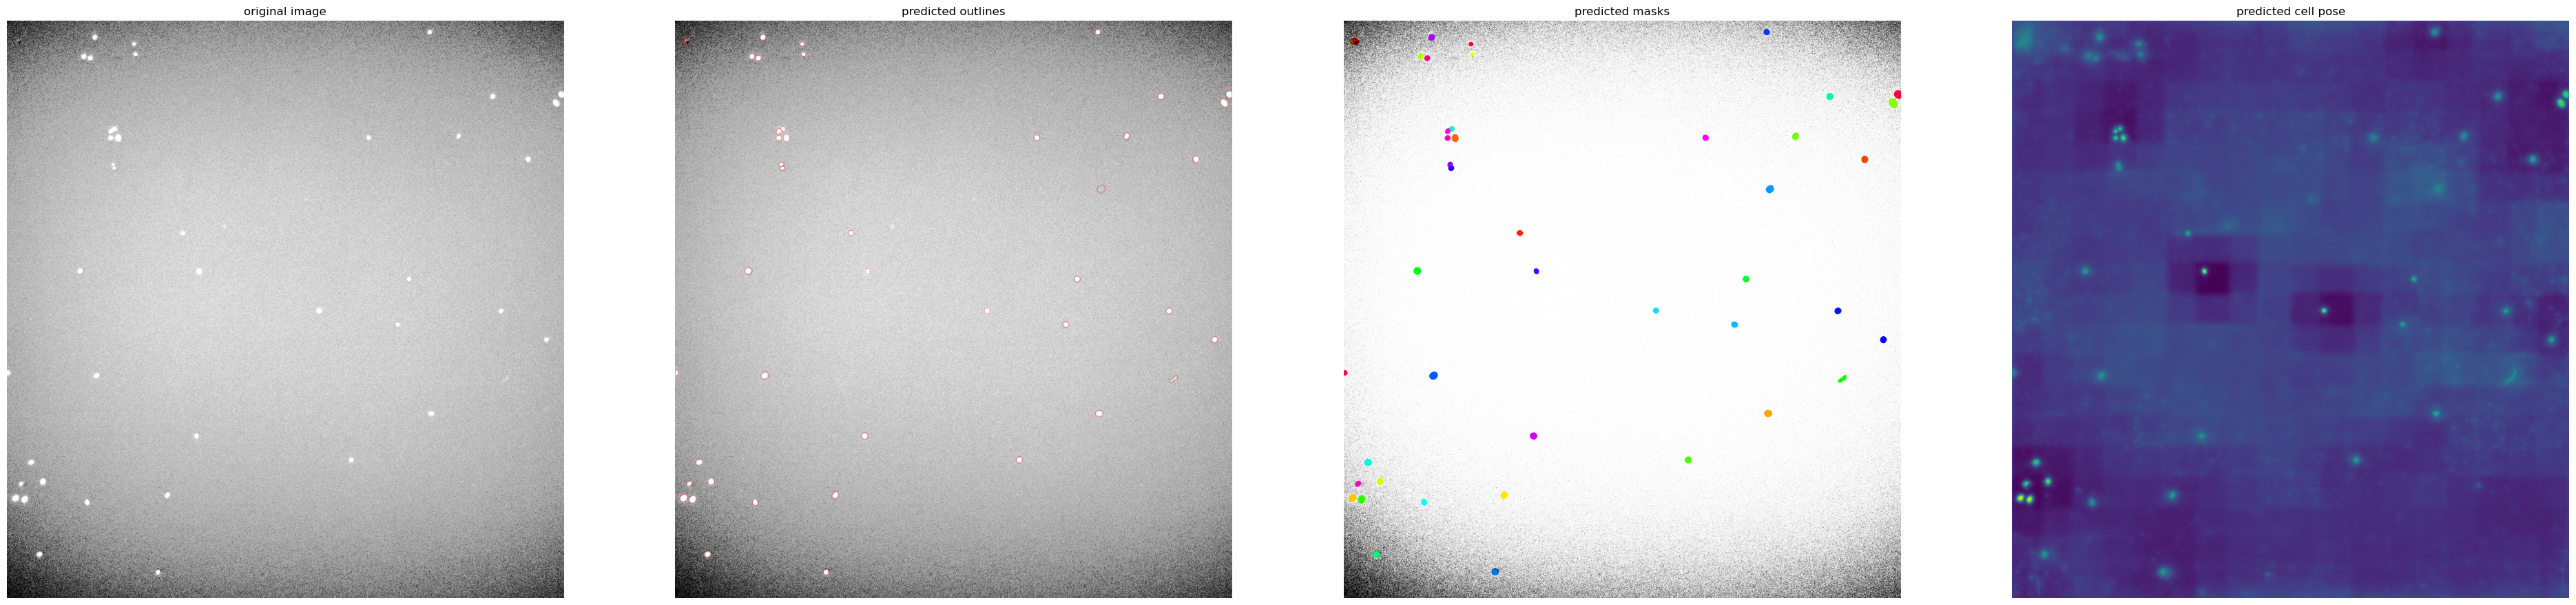

In [8]:

# === Step 1: Set thresholds ===
intensity_thresh = 0.0        # mean intensity in 0–255
min_diam = 13.0                # min diameter (in pixels)
max_diam = 70.0                # max diameter (in pixels)

# === Step 2: Compute region properties ===
props = regionprops(masks, intensity_image=scaled_img)

# === Step 3: Apply both filters ===
keep_labels = []
for p in props:
    diameter = 2.0 * np.sqrt(p.area / np.pi)  # circular equivalent
    if p.mean_intensity >= intensity_thresh and min_diam <= diameter <= max_diam:
        keep_labels.append(p.label)

# === Step 4: Create filtered mask ===
filtered_mask = np.isin(masks, keep_labels) * masks

print(f"Original objects: {len(props)}")
print(f"Kept after filtering: {len(keep_labels)}")
print(f"Intensity ≥ {intensity_thresh}, Diameter ∈ [{min_diam}, {max_diam}] px")

# === Step 5: Visualize filtered result ===
fig = plt.figure(figsize=(48, 16))
plot.show_segmentation(
    fig,
    scaled_img,         # input to Cellpose
    filtered_mask,      # filtered masks
    flows_list[0][2],   # flow_rgb
    [0, 0]              # grayscale mode
)
